# Sign Detection with Xception

### Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Model
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from keras.applications.inception_resnet_v2 import InceptionResNetV2

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Image Data Augmentation

In [2]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=0.2,
         rotation_range=10, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

data_dir = "ISL-Original/Training"
test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (299, 299),
                                           batch_size=64,
                                       subset='training',
                                           seed=46)
val_ds = test_datagen.flow_from_directory(data_dir,
                                     class_mode = 'categorical',
                                     target_size = (299, 299),
                                     batch_size=64,
                                          subset='validation',
                                     seed=46)

Found 8803 images belonging to 26 classes.
Found 2189 images belonging to 26 classes.


### Declare Metrics 

In [3]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - MobileNet

In [4]:
base_model = Xception(weights='imagenet', 
                              include_top=False, 
                              input_shape=(299, 299, 3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(26, activation="softmax")(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy',f1, precision,recall])

In [11]:
#Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.Xception(input_shape=(299,299,3),
                                              include_top=False,
                                              weights='imagenet')

base_model.trainable = False
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(26, activation='softmax')])

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [6]:
#fit the model
#it will take some time to train
# model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy',f1, precision,recall])
history = model.fit(train_ds, epochs =5, batch_size = 64,validation_data=val_ds)

Epoch 1/5
138/138 [==============================] - 2013s 15s/step - loss: 2.5080 - accuracy: 0.3681 - f1: 0.2706 - precision: 0.6240 - recall: 0.1884 - val_loss: 1.4443 - val_accuracy: 0.6085 - val_f1: 0.5386 - val_precision: 0.6469 - val_recall: 0.4624
Epoch 2/5
138/138 [==============================] - 2224s 16s/step - loss: 1.2062 - accuracy: 0.6402 - f1: 0.6157 - precision: 0.7774 - recall: 0.5141 - val_loss: 0.6634 - val_accuracy: 0.8296 - val_f1: 0.8283 - val_precision: 0.8733 - val_recall: 0.7884
Epoch 3/5
138/138 [==============================] - 2251s 16s/step - loss: 0.8534 - accuracy: 0.7410 - f1: 0.7404 - precision: 0.8320 - recall: 0.6684 - val_loss: 0.5165 - val_accuracy: 0.8556 - val_f1: 0.8630 - val_precision: 0.8909 - val_recall: 0.8371
Epoch 4/5
138/138 [==============================] - 2153s 16s/step - loss: 0.6456 - accuracy: 0.8009 - f1: 0.7982 - precision: 0.8600 - recall: 0.7457 - val_loss: 0.3083 - val_accuracy: 0.9045 - val_f1: 0.9038 - val_precision: 0.91

### Learning Curves - Graph 

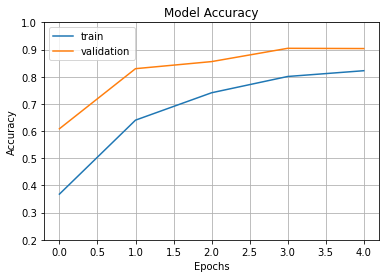

In [7]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.2,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

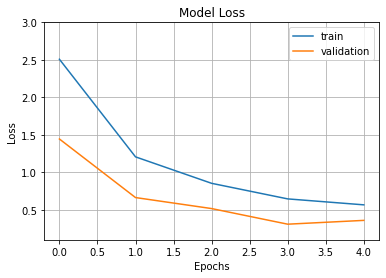

In [8]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0.1,ymax=3)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Evaluating the Model 

In [9]:
Y_pred = model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

Text(0.5, 33.0, 'Predicted label')

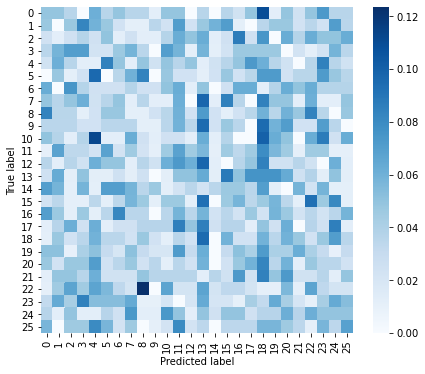

In [10]:
cf_mat = confusion_matrix(val_ds.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [11]:
model.save('xception_signd.h5')

In [12]:
labels = val_ds.classes
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.05      0.05      0.05        82
           1       0.00      0.00      0.00        84
           2       0.03      0.03      0.03        80
           3       0.07      0.07      0.07        85
           4       0.01      0.01      0.01        82
           5       0.00      0.00      0.00        83
           6       0.03      0.03      0.03        80
           7       0.01      0.01      0.01        82
           8       0.01      0.01      0.01        83
           9       0.03      0.01      0.02        84
          10       0.03      0.03      0.03        80
          11       0.05      0.07      0.06        88
          12       0.08      0.06      0.07        82
          13       0.04      0.06      0.05        79
          14       0.08      0.04      0.05        85
          15       0.05      0.05      0.05        86
          16       0.02      0.02      0.02        85
          17       0.01    

['G']

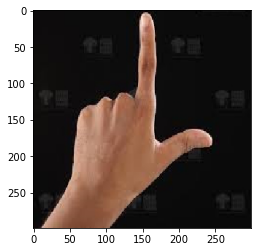

In [22]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_L.jpeg", target_size=(299, 299))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

In [23]:
loss, accuracy, f1_score, precision, recall = model.evaluate(val_ds, verbose=0)

In [24]:
print(f"Test Loss: ", loss)
print(f"Test Accuracy: ", accuracy)
print(f"Test Precision: ", precision)
print(f"Test Recall: ",recall)
print(f"Test F1 Score: ",f1_score)

Test Loss:  0.3589974343776703
Test Accuracy:  0.9036089777946472
Test Precision:  0.9126871824264526
Test Recall:  0.8933722376823425
Test F1 Score:  0.9028714299201965


In [25]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')

Test Loss:  35.9 %
Test Accuracy:  90.361 %
Test Precision:  91.269 %
Test Recall:  89.337 %
Test F1 Score:  90.287 %
